In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.0.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/'My Drive'/BME590_Machine_Learning

/content/drive/My Drive/BME590_Machine_Learning


In [0]:
from scipy.io import loadmat
data = loadmat('OASBUD.mat')['data'][0] # mat file is dict with header, we just want the data key (which is stored as a list of lists)
# each of the 100 data points consists of 7 arrays
# array 0: patient's unique ID
# array 1: first scan plane (first set of rf dta)
# array 2: second scan plane (second set of rf data)
# array 3: region of interest for first scan plane
# array 4: region of interest for second scan plane
# array 5: BI-RADS category (low, medium, high probability of malignancy)
# array 6: label (0 = benign, 1 = malignant)

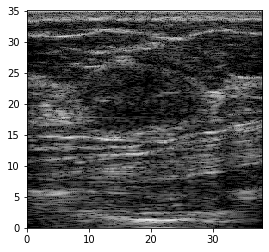

In [6]:
from scipy.signal import hilbert
# example image processing of first data point (both scan planes):
c = 1540
width = 38
fs = 40e6
rf1 = data[0][1]
roi1 = data[0][3]

def preprocessing(rf_data, db_threshold):
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    
    
plt.imshow(preprocessing(rf1,50),extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [0]:
# to get data and labels for all scans
dB_cutoff=50
labeled_data = []
for n in range(len(data)):
  labeled_data.append((preprocessing(data[n][1],dB_cutoff), data[n][3])) # data for scan 1, roi for scan 1
  labeled_data.append((preprocessing(data[n][2],dB_cutoff), data[n][4])) # data for scan 2, roi for scan 2

In [0]:
import random
augmented_labeled_data = []
crop_size = 224
for data in labeled_data:
  count = 0
  lower_perc = .35
  while count < 25:
    num_bad = 1
    start_x = random.randint(0, np.size(data[0], 0) - crop_size)
    start_y = random.randint(0, np.size(data[0], 1) - crop_size)
    new_image = data[0][start_x:start_x+crop_size, start_y:start_y+crop_size]
    new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
    num_ones = np.count_nonzero(new_roi == 1)
    while not ((crop_size**2)*lower_perc < num_ones < (crop_size**2)*.75):
      start_x = random.randint(0, np.size(data[0], 0) - crop_size)
      start_y = random.randint(0, np.size(data[0], 1) - crop_size)
      new_image = data[0][start_x:start_x+crop_size, start_y:start_y+crop_size]
      new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
      num_ones = np.count_nonzero(new_roi == 1)
      num_bad = num_bad + 1
      if num_bad%25 == 0:
        lower_perc = lower_perc/2
    count = count + 1
    augmented_labeled_data.append((np.stack((new_image/255.0, new_image/255.0, new_image/255.0), axis=2), new_roi))

In [0]:
# Data splitting for segmentation
x_train_seg,x_test_seg,y_train_seg,y_test_seg = \
    train_test_split(np.array([x[0] for x in augmented_labeled_data]), np.array([x[1] for x in augmented_labeled_data]), test_size=.2, random_state=13, shuffle=False)

y_train_seg = y_train_seg[..., np.newaxis]
y_test_seg = y_test_seg[..., np.newaxis]

BATCH_SIZE = 10

train_ds_seg = tf.data.Dataset.from_tensor_slices((x_train_seg, y_train_seg)).shuffle(4000).batch(BATCH_SIZE)
test_ds_seg = tf.data.Dataset.from_tensor_slices((x_test_seg, y_test_seg)).shuffle(1000).batch(BATCH_SIZE)

In [0]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# ==============================================================================
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

# pix2pix.upsample(filters, size)
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3, apply_dropout=True),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips): # puts in tuple so that they can be simultaneously indexed
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

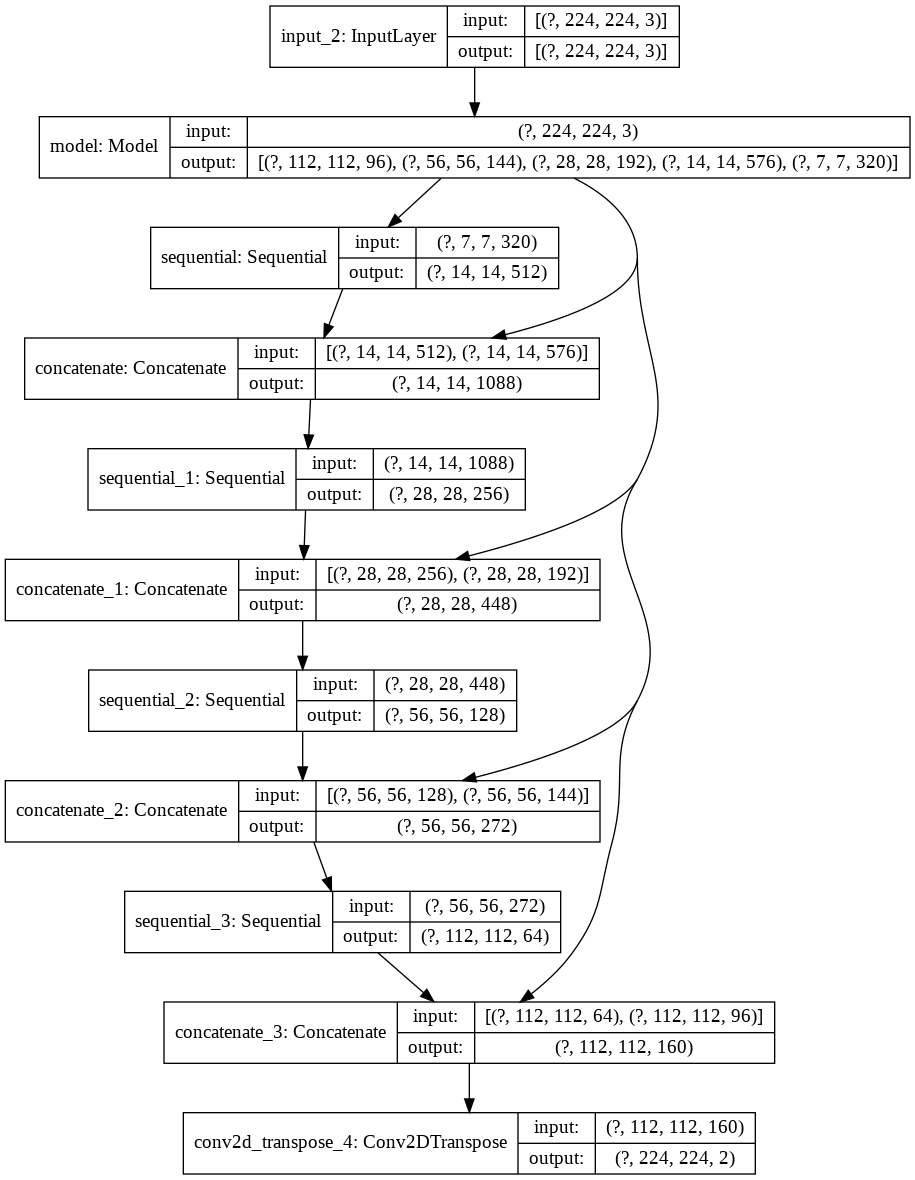

In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

Train for 20 steps, validate for 5 steps
Epoch 1/10
19/20 [===========================>..] - ETA: 3s - loss: 0.6665 - accuracy: 0.6514

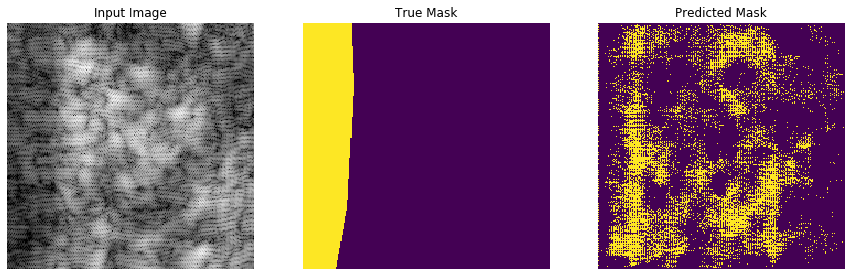


Sample Prediction after epoch 1

20/20 [==============================] - 130s 6s/step - loss: 0.6611 - accuracy: 0.6546 - val_loss: 0.6168 - val_accuracy: 0.6716
Epoch 2/10
19/20 [===========================>..] - ETA: 3s - loss: 0.4914 - accuracy: 0.7643

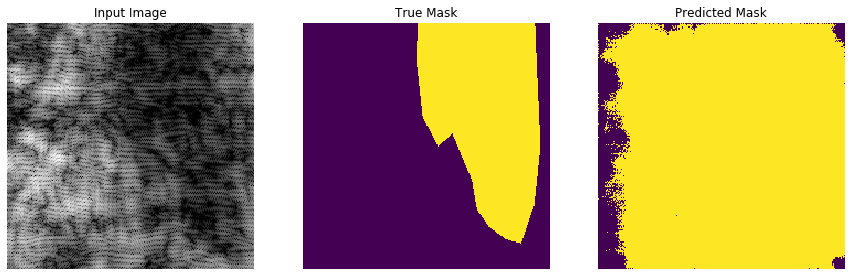


Sample Prediction after epoch 2

20/20 [==============================] - 89s 4s/step - loss: 0.4885 - accuracy: 0.7658 - val_loss: 2.2238 - val_accuracy: 0.4621
Epoch 3/10
19/20 [===========================>..] - ETA: 3s - loss: 0.4667 - accuracy: 0.7748

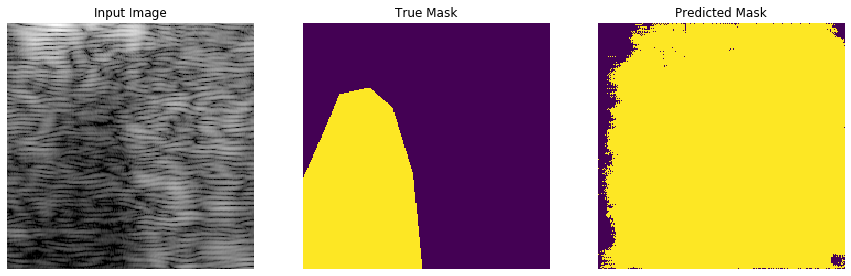


Sample Prediction after epoch 3

20/20 [==============================] - 88s 4s/step - loss: 0.4672 - accuracy: 0.7739 - val_loss: 1.6977 - val_accuracy: 0.4223
Epoch 4/10
19/20 [===========================>..] - ETA: 3s - loss: 0.4296 - accuracy: 0.8012

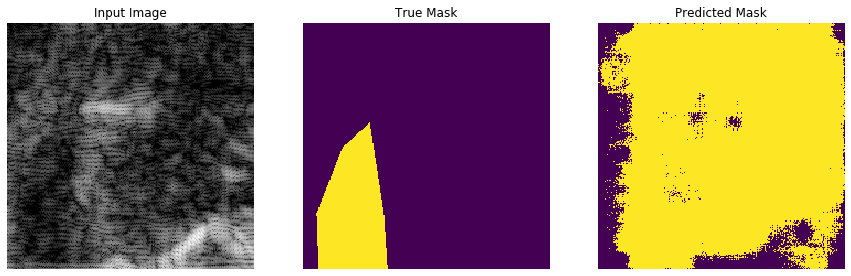


Sample Prediction after epoch 4

20/20 [==============================] - 88s 4s/step - loss: 0.4309 - accuracy: 0.8000 - val_loss: 0.8683 - val_accuracy: 0.5343
Epoch 5/10
19/20 [===========================>..] - ETA: 3s - loss: 0.4648 - accuracy: 0.7780

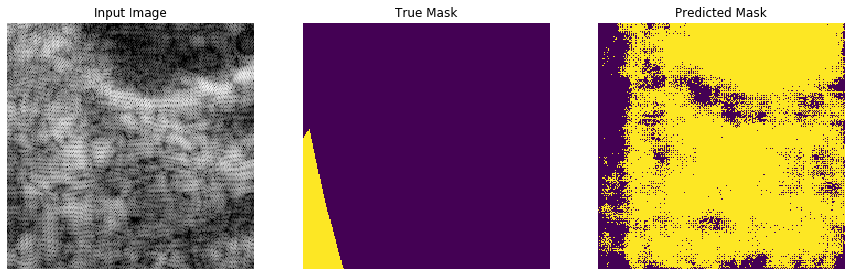


Sample Prediction after epoch 5

20/20 [==============================] - 88s 4s/step - loss: 0.4610 - accuracy: 0.7801 - val_loss: 0.9393 - val_accuracy: 0.5046
Epoch 6/10
19/20 [===========================>..] - ETA: 3s - loss: 0.4356 - accuracy: 0.7926

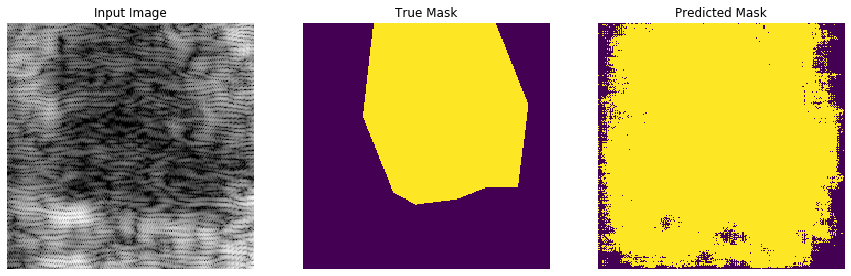


Sample Prediction after epoch 6

20/20 [==============================] - 88s 4s/step - loss: 0.4336 - accuracy: 0.7939 - val_loss: 0.7863 - val_accuracy: 0.5344
Epoch 7/10
 3/20 [===>..........................] - ETA: 1:00 - loss: 0.4235 - accuracy: 0.7970

In [0]:
# function for displaying the values from show predictions
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# creates an image out of the predicted mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# model predicts mask based on image, displays the image, actual mask, and predicted mask
def show_predictions():
    for image, mask in train_ds_seg.take(1):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
    
# optional callback class to display the predicted mask vs. actual mask for each image as the model trains
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10

tf.keras.backend.clear_session()
results = model.fit(train_ds_seg, epochs=EPOCHS,
                          steps_per_epoch= 4000 // EPOCHS // BATCH_SIZE,
                          validation_steps= 1000 // EPOCHS // BATCH_SIZE,
                          validation_data=test_ds_seg,
                          callbacks=[DisplayCallback()]) # optional callback

In [0]:
# Visualization
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [0]:
# Now, add a physical layer to the model and optimize those variables:
# Physical layer: aperture width - upsampling for decreased aperture width
from scipy import interpolate
interpolation = tf.Variable(1000)
def aperture(data):  # input will be the batch of data passed into it
  sampled = []
  for n in range(len(data)):
    for i in range(1,3):
      x = np.array(range(data[n][i].shape[1]))
      y = np.array(range(data[n][i].shape[0]))
      xx,yy=np.meshgrid(x,y)  
      f = interpolate.interp2d(x, y, data[n][i], kind='linear')
      x2 = np.linspace(0, data[n][i].shape[1], interpolation)
      y2 = np.linspace(0, data[n][i].shape[0], interpolation)
      sampled.append(f(x2,y2))
  return sampled

sample=np.array(aperture(data))
print(sample.shape)

# Other physical layer: dB threshold used to process images
db_threshold = tf.Variable(50)
def preprocessing(rf_data): # input will be the raw rf data passed into it
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)